# Advanced Retrieval with LangChain


  - **Evaluate with Ragas** - **Check bottom of notebook (After "Activity 2" for Homework details)**

## Task 1: Getting Dependencies!

We're going to need a few specific LangChain community packages, like OpenAI (for our [LLM](https://platform.openai.com/docs/models) and [Embedding Model](https://platform.openai.com/docs/guides/embeddings)) and Cohere (for our [Reranker](https://cohere.com/rerank)).

> You do not need to run the following cells if you are running this notebook locally.

In [1]:
!pip install -qU langchain langchain-openai langchain-cohere rank_bm25

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 415.4/415.4 kB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 66.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 100.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 5.0 MB/s eta 0:00:00


We're also going to be leveraging [Qdrant's](https://qdrant.tech/documentation/frameworks/langchain/) (pronounced "Quadrant") VectorDB in "memory" mode (so we can leverage it locally in our colab environment).

In [2]:
!pip install -qU qdrant-client

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 306.7/306.7 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 14.7 MB/s eta 0:00:00


We'll also provide our OpenAI key, as well as our Cohere API key.

In [3]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API Key:")

Enter your OpenAI API Key:··········


## Task 2: Data Collection and Preparation

We'll be using some reviews from the 4 movies in the John Wick franchise today to explore the different retrieval strategies.

These were obtained from IMDB, and are available in the [AIM Data Repository](https://github.com/AI-Maker-Space/DataRepository).

### Data Collection

We can simply `wget` these from GitHub.

You could use any review data you wanted in this step - just be careful to make sure your metadata is aligned with your choice.

In [4]:
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw1.csv -O john_wick_1.csv
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw2.csv -O john_wick_2.csv
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw3.csv -O john_wick_3.csv
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw4.csv -O john_wick_4.csv

--2025-03-09 22:14:32--  https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19628 (19K) [text/plain]
Saving to: ‘john_wick_1.csv’

john_wick_1.csv     100%[===================>]  19.17K  --.-KB/s    in 0.001s  

2025-03-09 22:14:33 (26.6 MB/s) - ‘john_wick_1.csv’ saved [19628/19628]

--2025-03-09 22:14:33--  https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw2.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14747 (14K) [text/plain]
Sa

### Data Preparation

We want to make sure all our documents have the relevant metadata for the various retrieval strategies we're going to be applying today.

- Self-Query: Wants as much metadata as we can provide
- Time-weighted: Wants temporal data

> NOTE: While we're creating a temporal relationship based on when these movies came out for illustrative purposes, it needs to be clear that the "time-weighting" in the Time-weighted Retriever is based on when the document was *accessed* last - not when it was created.

In [5]:
from langchain_community.document_loaders.csv_loader import CSVLoader
from datetime import datetime, timedelta

documents = []

for i in range(1, 5):
  loader = CSVLoader(
      file_path=f"john_wick_{i}.csv",
      metadata_columns=["Review_Date", "Review_Title", "Review_Url", "Author", "Rating"]
  )

  movie_docs = loader.load()
  for doc in movie_docs:

    # Add the "Movie Title" (John Wick 1, 2, ...)
    doc.metadata["Movie_Title"] = f"John Wick {i}"

    # convert "Rating" to an `int`, if no rating is provided - assume 0 rating
    doc.metadata["Rating"] = int(doc.metadata["Rating"]) if doc.metadata["Rating"] else 0

    # newer movies have a more recent "last_accessed_at"
    doc.metadata["last_accessed_at"] = datetime.now() - timedelta(days=4-i)

  documents.extend(movie_docs)

Let's look at an example document to see if everything worked as expected!

In [6]:
documents[0]

Document(metadata={'source': 'john_wick_1.csv', 'row': 0, 'Review_Date': '6 May 2015', 'Review_Title': ' Kinetic, concise, and stylish; John Wick kicks ass.\n', 'Review_Url': '/review/rw3233896/?ref_=tt_urv', 'Author': 'lnvicta', 'Rating': 8, 'Movie_Title': 'John Wick 1', 'last_accessed_at': datetime.datetime(2025, 3, 6, 22, 14, 40, 883376)}, page_content=": 0\nReview: The best way I can describe John Wick is to picture Taken but instead of Liam Neeson it's Keanu Reeves and instead of his daughter it's his dog. That's essentially the plot of the movie. John Wick (Reeves) is out to seek revenge on the people who took something he loved from him. It's a beautifully simple premise for an action movie - when action movies get convoluted, they get bad i.e. A Good Day to Die Hard. John Wick gives the viewers what they want: Awesome action, stylish stunts, kinetic chaos, and a relatable hero to tie it all together. John Wick succeeds in its simplicity.")

## Task 3: Setting up QDrant!

Now that we have our documents, let's create a QDrant VectorStore with the collection name "JohnWick".

We'll leverage OpenAI's [`text-embedding-3-small`](https://openai.com/blog/new-embedding-models-and-api-updates) because it's a very powerful (and low-cost) embedding model.

> NOTE: We'll be creating additional vectorstores where necessary, but this pattern is still extremely useful.

In [7]:
from langchain_community.vectorstores import Qdrant
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

vectorstore = Qdrant.from_documents(
    documents,
    embeddings,
    location=":memory:",
    collection_name="JohnWick"
)

## Task 4: Naive RAG Chain

Since we're focusing on the "R" in RAG today - we'll create our Retriever first.

### R - Retrieval

This naive retriever will simply look at each review as a document, and use cosine-similarity to fetch the 10 most relevant documents.

> NOTE: We're choosing `10` as our `k` here to provide enough documents for our reranking process later

In [8]:
naive_retriever = vectorstore.as_retriever(search_kwargs={"k" : 10})

### A - Augmented

We're going to go with a standard prompt for our simple RAG chain today! Nothing fancy here, we want this to mostly be about the Retrieval process.

In [9]:
from langchain_core.prompts import ChatPromptTemplate

RAG_TEMPLATE = """\
You are a helpful and kind assistant. Use the context provided below to answer the question.

If you do not know the answer, or are unsure, say you don't know.

Query:
{question}

Context:
{context}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_TEMPLATE)

### G - Generation

We're going to leverage `gpt-3.5-turbo` as our LLM today, as - again - we want this to largely be about the Retrieval process.

In [10]:
from langchain_openai import ChatOpenAI

chat_model = ChatOpenAI()

### LCEL RAG Chain

We're going to use LCEL to construct our chain.

> NOTE: This chain will be exactly the same across the various examples with the exception of our Retriever!

In [11]:
from langchain_core.runnables import RunnablePassthrough
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser

naive_retrieval_chain = (
    # INVOKE CHAIN WITH: {"question" : "<<SOME USER QUESTION>>"}
    # "question" : populated by getting the value of the "question" key
    # "context"  : populated by getting the value of the "question" key and chaining it into the base_retriever
    {"context": itemgetter("question") | naive_retriever, "question": itemgetter("question")}
    # "context"  : is assigned to a RunnablePassthrough object (will not be called or considered in the next step)
    #              by getting the value of the "context" key from the previous step
    | RunnablePassthrough.assign(context=itemgetter("context"))
    # "response" : the "context" and "question" values are used to format our prompt object and then piped
    #              into the LLM and stored in a key called "response"
    # "context"  : populated by getting the value of the "context" key from the previous step
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's see how this simple chain does on a few different prompts.

> NOTE: You might think that we've cherry picked prompts that showcase the individual skill of each of the retrieval strategies - you'd be correct!

In [39]:
naive_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

"Yes, people generally liked John Wick based on the reviews provided. It was praised for its slickness, brilliance in action sequences, Keanu Reeves' performance, and overall entertainment value."

In [40]:
naive_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

"I don't know if any reviews have a rating of 10."

In [41]:
naive_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

"In John Wick, an ex-hitman comes out of retirement to seek vengeance against the gangsters who killed his dog and took everything from him. It's a story filled with action, suspense, and relentless vendetta. John Wick unleashes a maelstrom of destruction against those who try to chase him, leading to intense shootouts, fights, and plenty of action."

Overall, this is not bad! Let's see if we can make it better!

## Task 5: Best-Matching 25 (BM25) Retriever

Taking a step back in time - [BM25](https://www.nowpublishers.com/article/Details/INR-019) is based on [Bag-Of-Words](https://en.wikipedia.org/wiki/Bag-of-words_model) which is a sparse representation of text.

In essence, it's a way to compare how similar two pieces of text are based on the words they both contain.

This retriever is very straightforward to set-up! Let's see it happen down below!


In [53]:
from langchain_community.retrievers import BM25Retriever

bm25_retriever = BM25Retriever.from_documents(documents)

We'll construct the same chain - only changing the retriever.

In [54]:
bm25_retrieval_chain = (
    {"context": itemgetter("question") | bm25_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's look at the responses!

In [55]:
bm25_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

'Based on the reviews provided, opinions about the John Wick movies vary. Some people really enjoyed the action and style of the first movie, while others found the fourth installment weak and lacking substance. So, it seems that not everyone generally liked John Wick movies.'

In [56]:
bm25_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

"I'm sorry, none of the reviews in the provided context have a rating of 10."

In [57]:
bm25_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'In John Wick, the main character is an assassin seeking revenge for the death of his beloved dog, given to him by his deceased wife. The action scenes are beautifully choreographed, and the storyline is emotional for an action movie. It is highly recommended for those who enjoy action films.'

It's not clear that this is better or worse - but the `I don't know` isn't great!

## Task 6: Contextual Compression (Using Reranking)

Contextual Compression is a fairly straightforward idea: We want to "compress" our retrieved context into just the most useful bits.

There are a few ways we can achieve this - but we're going to look at a specific example called reranking.

The basic idea here is this:

- We retrieve lots of documents that are very likely related to our query vector
- We "compress" those documents into a smaller set of *more* related documents using a reranking algorithm.

We'll be leveraging Cohere's Rerank model for our reranker today!

All we need to do is the following:

- Create a basic retriever
- Create a compressor (reranker, in this case)

That's it!

Let's see it in the code below!

In [97]:
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain_cohere import CohereRerank

compressor = CohereRerank(model="rerank-english-v3.0")
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=naive_retriever
)

Let's create our chain again, and see how this does!

In [98]:
contextual_compression_retrieval_chain = (
    {"context": itemgetter("question") | compression_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

In [99]:
contextual_compression_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

'Yes, people generally liked John Wick based on the reviews provided.'

In [100]:
contextual_compression_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there is a review with a rating of 10 for the movie "John Wick 3." Here is the URL to that review: \'/review/rw4854296/?ref_=tt_urv\''

In [101]:
contextual_compression_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

"In John Wick, after resolving his issues with the Russian mafia, John Wick is visited by a mobster named Santino D'Antonio who asks for his help. When John refuses, Santino blows up his house. John Wick is then asked to kill Santino's sister in Rome, and when he does, Santino puts a contract on John, attracting professional killers from everywhere. Wick promises to kill Santino in retaliation."

We'll need to rely on something like Ragas to help us get a better sense of how this is performing overall - but it "feels" better!

## Task 7: Multi-Query Retriever

Typically in RAG we have a single query - the one provided by the user.

What if we had....more than one query!

In essence, a Multi-Query Retriever works by:

1. Taking the original user query and creating `n` number of new user queries using an LLM.
2. Retrieving documents for each query.
3. Using all unique retrieved documents as context

So, how is it to set-up? Not bad! Let's see it down below!



In [66]:
from langchain.retrievers.multi_query import MultiQueryRetriever

multi_query_retriever = MultiQueryRetriever.from_llm(
    retriever=naive_retriever, llm=chat_model
)

In [67]:
multi_query_retrieval_chain = (
    {"context": itemgetter("question") | multi_query_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

In [69]:
multi_query_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

'Yes, people generally liked John Wick based on the reviews provided in the context.'

In [ ]:
multi_query_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

"I'm sorry, there are no reviews with a rating of 10 in the provided context."

In [ ]:
multi_query_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

"In John Wick, the story follows a retired assassin named John Wick who comes out of retirement after someone kills his dog and steals his car, leading to a lot of carnage. He is then called on to pay off an old debt by helping take over the Assassin's Guild by traveling to Italy, Canada, and Manhattan to eliminate numerous assassins."

## Task 8: Parent Document Retriever

A "small-to-big" strategy - the Parent Document Retriever works based on a simple strategy:

1. Each un-split "document" will be designated as a "parent document" (You could use larger chunks of document as well, but our data format allows us to consider the overall document as the parent chunk)
2. Store those "parent documents" in a memory store (not a VectorStore)
3. We will chunk each of those documents into smaller documents, and associate them with their respective parents, and store those in a VectorStore. We'll call those "child chunks".
4. When we query our Retriever, we will do a similarity search comparing our query vector to the "child chunks".
5. Instead of returning the "child chunks", we'll return their associated "parent chunks".

Okay, maybe that was a few steps - but the basic idea is this:

- Search for small documents
- Return big documents

The intuition is that we're likely to find the most relevant information by limiting the amount of semantic information that is encoded in each embedding vector - but we're likely to miss relevant surrounding context if we only use that information.

Let's start by creating our "parent documents" and defining a `RecursiveCharacterTextSplitter`.

In [70]:
from langchain.retrievers import ParentDocumentRetriever
from langchain.storage import InMemoryStore
from langchain_text_splitters import RecursiveCharacterTextSplitter
from qdrant_client import QdrantClient, models

parent_docs = documents
child_splitter = RecursiveCharacterTextSplitter(chunk_size=200)

We'll need to set up a new QDrant vectorstore - and we'll use another useful pattern to do so!

> NOTE: We are manually defining our embedding dimension, you'll need to change this if you're using a different embedding model.

In [71]:
client = QdrantClient(location=":memory:")

client.create_collection(
    collection_name="full_documents",
    vectors_config=models.VectorParams(size=1536, distance=models.Distance.COSINE)
)

parent_document_vectorstore = Qdrant(
    collection_name="full_documents", embeddings=OpenAIEmbeddings(model="text-embedding-3-small"), client=client
)

<ipython-input-71-4887b10d4438>:8: LangChainDeprecationWarning: The class `Qdrant` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-qdrant package and should be used instead. To use it run `pip install -U :class:`~langchain-qdrant` and import as `from :class:`~langchain_qdrant import Qdrant``.
  parent_document_vectorstore = Qdrant(


Now we can create our `InMemoryStore` that will hold our "parent documents" - and build our retriever!

In [72]:
store = InMemoryStore()

parent_document_retriever = ParentDocumentRetriever(
    vectorstore = parent_document_vectorstore,
    docstore=store,
    child_splitter=child_splitter,
)

By default, this is empty as we haven't added any documents - let's add some now!

In [73]:
parent_document_retriever.add_documents(parent_docs, ids=None)

We'll create the same chain we did before - but substitute our new `parent_document_retriever`.

In [74]:
parent_document_retrieval_chain = (
    {"context": itemgetter("question") | parent_document_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's give it a whirl!

In [75]:
parent_document_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

'Overall, opinions on John Wick seem to be divided. Some people really enjoy the series and find it consistent and well-received, while others have strong negative opinions about specific installments, like John Wick 4. It seems like there is a range of views on whether people generally like John Wick, so it ultimately depends on individual preferences.'

In [ ]:
parent_document_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there is a review with a rating of 10. Here is the URL to that review: /review/rw4854296/?ref_=tt_urv'

In [ ]:
parent_document_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

"In John Wick, John Wick is a retired assassin who comes out of retirement to seek revenge after someone kills his dog and steals his car. He is then called on to pay off an old debt by helping Ian McShane take over the Assassin's Guild by flying around to Italy, Canada, and Manhattan and killing numerous assassins."

Overall, the performance *seems* largely the same. We can leverage a tool like [Ragas]() to more effectively answer the question about the performance.

## Task 9: Ensemble Retriever

In brief, an Ensemble Retriever simply takes 2, or more, retrievers and combines their retrieved documents based on a rank-fusion algorithm.

In this case - we're using the [Reciprocal Rank Fusion](https://plg.uwaterloo.ca/~gvcormac/cormacksigir09-rrf.pdf) algorithm.

Setting it up is as easy as providing a list of our desired retrievers - and the weights for each retriever.

In [111]:
from langchain.retrievers import EnsembleRetriever

retriever_list = [bm25_retriever, naive_retriever, parent_document_retriever, compression_retriever, multi_query_retriever]
equal_weighting = [1/len(retriever_list)] * len(retriever_list)

ensemble_retriever = EnsembleRetriever(
    retrievers=retriever_list, weights=equal_weighting
)

We'll pack *all* of these retrievers together in an ensemble.

In [112]:
ensemble_retrieval_chain = (
    {"context": itemgetter("question") | ensemble_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's look at our results!

In [113]:
ensemble_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

'Yes, people generally liked John Wick based on the reviews provided in the context.'

In [ ]:
ensemble_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

"Yes, there is one review with a rating of 10. Here is the URL to that review: '/review/rw4854296/?ref_=tt_urv'"

In [ ]:
ensemble_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'John Wick is an action-packed movie series that follows the story of a retired hitman, John Wick, who seeks vengeance after gangsters kill his dog and steal his car. This leads to a series of violent confrontations with various enemies throughout the movies.'

## Task 10: Semantic Chunking

While this is not a retrieval method - it *is* an effective way of increasing retrieval performance on corpora that have clean semantic breaks in them.

Essentially, Semantic Chunking is implemented by:

1. Embedding all sentences in the corpus.
2. Combining or splitting sequences of sentences based on their semantic similarity based on a number of [possible thresholding methods](https://python.langchain.com/docs/how_to/semantic-chunker/):
  - `percentile`
  - `standard_deviation`
  - `interquartile`
  - `gradient`
3. Each sequence of related sentences is kept as a document!

Let's see how to implement this!

> NOTE: You do not need to run this cell if you're running this locally

In [85]:
!pip install -qU langchain_experimental

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.2/209.2 kB 3.4 MB/s eta 0:00:00


We'll use the `percentile` thresholding method for this example which will:

Calculate all distances between sentences, and then break apart sequences of setences that exceed a given percentile among all distances.

In [86]:
from langchain_experimental.text_splitter import SemanticChunker

semantic_chunker = SemanticChunker(
    embeddings,
    breakpoint_threshold_type="percentile"
)

Now we can split our documents.

In [87]:
semantic_documents = semantic_chunker.split_documents(documents)

Let's create a new vector store.

In [88]:
semantic_vectorstore = Qdrant.from_documents(
    semantic_documents,
    embeddings,
    location=":memory:",
    collection_name="JohnWickSemantic"
)

We'll use naive retrieval for this example.

In [89]:
semantic_retriever = semantic_vectorstore.as_retriever(search_kwargs={"k" : 10})

Finally we can create our classic chain!

In [90]:
semantic_retrieval_chain = (
    {"context": itemgetter("question") | semantic_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

And view the results!

In [91]:
semantic_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

'Based on the reviews provided, it seems that people generally liked John Wick. There were positive comments about the action, the character of John Wick, and the style of the film.'

In [ ]:
semantic_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there is one review with a rating of 10 for the movie "John Wick 3". Here is the URL to that review: /review/rw4854296/?ref_=tt_urv'

In [ ]:
semantic_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'John Wick is an ultra-violent movie series that follows the story of an ex-hitman seeking revenge after gangsters killed his dog and took everything from him. The first installment features John Wick coming out of retirement to track down those responsible. The series is known for its elaborate action sequences, vivid choreography, and intense violence.'

#### 🏗️ Activity #1

Your task is to evaluate the various Retriever methods against eachother.

You are expected to:

1. Create a "golden dataset"
 - Use Synthetic Data Generation (powered by Ragas, or otherwise) to create this dataset
2. Evaluate each retriever with *retriever specific* Ragas metrics
 - Semantic Chunking is not considered a retriever method and will not be required for marks, but you may find it useful to do a "semantic chunking on" vs. "semantic chunking off" comparision between them
3. Compile these in a list and write a small paragraph about which is best for this particular data and why.

Your analysis should factor in:
  - Cost
  - Latency
  - Performance

> NOTE: This is **NOT** required to be completed in class. Please spend time in your breakout rooms creating a plan before moving on to writing code.

##### HINTS:

- LangSmith provides detailed information about latency and cost.

## Evaluation of all Retrievers using RAGAS and Langsmith

In [22]:
import os
import getpass

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangChain API Key:")

LangChain API Key:··········


In [49]:
from uuid import uuid4

os.environ["LANGCHAIN_PROJECT"] = "Evaluate different Retriever using Ragas- 4e3c7b7b"

In [14]:
os.environ["COHERE_API_KEY"] = getpass.getpass("Cohere API Key:")

Cohere API Key:··········


In [16]:
!mkdir data

In [17]:
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw1.csv -O data/john_wick_1.csv
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw2.csv -O data/john_wick_2.csv
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw3.csv -O data/john_wick_3.csv
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw4.csv -O data/john_wick_4.csv

--2025-03-09 22:16:30--  https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19628 (19K) [text/plain]
Saving to: ‘data/john_wick_1.csv’

data/john_wick_1.cs 100%[===================>]  19.17K  --.-KB/s    in 0.001s  

2025-03-09 22:16:30 (23.7 MB/s) - ‘data/john_wick_1.csv’ saved [19628/19628]

--2025-03-09 22:16:30--  https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw2.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14747 (14K) [text

In [27]:
pip install -qU ragas==0.2.10 unstructured langsmith


In [30]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o"))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

In [31]:
from langchain_community.document_loaders import DirectoryLoader

path = "data/"
loader = DirectoryLoader(path, glob="*.csv")
docs = loader.load()

In [32]:
from ragas.testset.graph import KnowledgeGraph

kg = KnowledgeGraph()
kg

KnowledgeGraph(nodes: 0, relationships: 0)

In [33]:
from ragas.testset.graph import Node, NodeType

for doc in docs:
    kg.nodes.append(
        Node(
            type=NodeType.DOCUMENT,
            properties={"page_content": doc.page_content, "document_metadata": doc.metadata}
        )
    )
kg

KnowledgeGraph(nodes: 4, relationships: 0)

In [34]:
from ragas.testset.transforms import default_transforms, apply_transforms

transformer_llm = generator_llm
embedding_model = generator_embeddings

default_transforms = default_transforms(documents=docs, llm=transformer_llm, embedding_model=embedding_model)
apply_transforms(kg, default_transforms)
kg

Applying HeadlinesExtractor:   0%|          | 0/4 [00:00<?, ?it/s]

Applying HeadlineSplitter:   0%|          | 0/4 [00:00<?, ?it/s]

Applying SummaryExtractor:   0%|          | 0/4 [00:00<?, ?it/s]

Applying CustomNodeFilter:   0%|          | 0/13 [00:00<?, ?it/s]

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/30 [00:00<?, ?it/s]

Applying [CosineSimilarityBuilder, OverlapScoreBuilder]:   0%|          | 0/2 [00:00<?, ?it/s]

KnowledgeGraph(nodes: 17, relationships: 44)

In [35]:
kg.save("ai_across_years_kg.json")
ai_across_years_kg = KnowledgeGraph.load("ai_across_years_kg.json")
ai_across_years_kg

KnowledgeGraph(nodes: 17, relationships: 44)

In [36]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=embedding_model, knowledge_graph=ai_across_years_kg)

In [37]:
from ragas.testset.synthesizers import default_query_distribution, SingleHopSpecificQuerySynthesizer, MultiHopAbstractQuerySynthesizer, MultiHopSpecificQuerySynthesizer

query_distribution = [
        (SingleHopSpecificQuerySynthesizer(llm=generator_llm), 0.5),
        (MultiHopAbstractQuerySynthesizer(llm=generator_llm), 0.25),
        (MultiHopSpecificQuerySynthesizer(llm=generator_llm), 0.25),
]

In [38]:
testset = generator.generate(testset_size=10, query_distribution=query_distribution)
testset.to_pandas()

Generating personas:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/11 [00:00<?, ?it/s]

,user_input,reference_contexts,reference,synthesizer_name
0,"Yo, what's up with that Mustang in John Wick 2...","[Stab, kick, shoot, repeat. Stab, kick, shoot,...","In 'John Wick: Chapter 2,' John Wick retrieves...",single_hop_specifc_query_synthesizer
1,"What John Wick do in Italy, huh?",[there's no doubt it'd be John Wick. Dancing t...,"In John Wick: Chapter 2, John Wick travels to ...",single_hop_specifc_query_synthesizer
2,"What John Wick: Chapter 2 about, is it good ac...",[Review_Date Author Rating Review_Title Review...,John Wick: Chapter 2 is a slick action thrille...,single_hop_specifc_query_synthesizer
3,Why everyone want the 14 million dollar for Jo...,[the fighting scenes get dull after a while\n ...,The plot of 'John Wick: Chapter 3 - Parabellum...,single_hop_specifc_query_synthesizer
4,What role do the Triads play in the action seq...,[needs to kill so it is literally and executio...,"In John Wick: Chapter 3 - Parabellum, the Tria...",single_hop_specifc_query_synthesizer
5,Why John Wick movies have so many assassins an...,"[<1-hop>\n\nStab, kick, shoot, repeat. Stab, k...",The John Wick film series is known for its hig...,multi_hop_abstract_query_synthesizer
6,Why do some reviews describe the fighting scen...,[<1-hop>\n\nthe fighting scenes get dull after...,Some reviews describe the fighting scenes in J...,multi_hop_abstract_query_synthesizer
7,"How does the John Wick film series, particular...","[<1-hop>\n\nStab, kick, shoot, repeat. Stab, k...","The John Wick film series, especially Chapter ...",multi_hop_abstract_query_synthesizer
8,How does the film 'John Wick' compare to 'Take...,"[<1-hop>\n\nand does it with such confidence, ...",The film 'John Wick' is often compared to 'Tak...,multi_hop_specific_query_synthesizer
9,Why do some people think John Wick: Chapter 3 ...,[<1-hop>\n\nthe fighting scenes get dull after...,Some people think John Wick: Chapter 3 - Parab...,multi_hop_specific_query_synthesizer


In [39]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)
dataset = generator.generate_with_langchain_docs(docs, testset_size=10)

Applying HeadlinesExtractor:   0%|          | 0/4 [00:00<?, ?it/s]

Applying HeadlineSplitter:   0%|          | 0/4 [00:00<?, ?it/s]

Applying SummaryExtractor:   0%|          | 0/4 [00:00<?, ?it/s]

Applying CustomNodeFilter:   0%|          | 0/13 [00:00<?, ?it/s]

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/30 [00:00<?, ?it/s]

Applying [CosineSimilarityBuilder, OverlapScoreBuilder]:   0%|          | 0/2 [00:00<?, ?it/s]

Generating personas:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/12 [00:00<?, ?it/s]

In [40]:
dataset.to_pandas()

,user_input,reference_contexts,reference,synthesizer_name
0,What makes 'John Wick: Chapter 2' stand out as...,"[Stab, kick, shoot, repeat. Stab, kick, shoot,...",'John Wick: Chapter 2' is an American movie fr...,single_hop_specifc_query_synthesizer
1,Wut happins in Rome in John Wick: Chapter 2?,[there's no doubt it'd be John Wick. Dancing t...,"In John Wick: Chapter 2, John Wick travels to ...",single_hop_specifc_query_synthesizer
2,What role does Keanu Reeves play in John Wick:...,[Review_Date Author Rating Review_Title Review...,"Keanu Reeves plays the role of John Wick, an e...",single_hop_specifc_query_synthesizer
3,Why is John Wick referred to as Baba Yaga in t...,[the fighting scenes get dull after a while\n ...,Assassin John Wick is referred to as Baba Yaga...,single_hop_specifc_query_synthesizer
4,"How does the John Wick film series, particular...","[<1-hop>\n\nStab, kick, shoot, repeat. Stab, k...","The John Wick film series, especially Chapter ...",multi_hop_abstract_query_synthesizer
5,"How does the John Wick film series, particular...","[<1-hop>\n\nStab, kick, shoot, repeat. Stab, k...","The John Wick film series, especially Chapter ...",multi_hop_abstract_query_synthesizer
6,How do the choreographed fight sequences in Jo...,[<1-hop>\n\nI was rolling my eyes the whole ti...,The choreographed fight sequences in John Wick...,multi_hop_abstract_query_synthesizer
7,"How does the John Wick film series, particular...","[<1-hop>\n\nStab, kick, shoot, repeat. Stab, k...","The John Wick film series, especially Chapter ...",multi_hop_abstract_query_synthesizer
8,How does the character of John Wick evolve fro...,[<1-hop>\n\ncrime action thrillers rarely deli...,"In the first 'John Wick' film, the character o...",multi_hop_specific_query_synthesizer
9,Why do some reviewers think John Wick: Chapter...,[<1-hop>\n\nReview_Date Author Rating Review_T...,Some reviewers compare John Wick: Chapter 3 - ...,multi_hop_specific_query_synthesizer


##Evaluating naive_retrieval with Ragas

In [55]:
import time
from langchain.callbacks import get_openai_callback
from langsmith.run_helpers import traceable
from langsmith import Client

client = Client()
project_name = "Evaluate different Retriever using Ragas- 4e3c7b7b"

for test_row in dataset:
  start_time = time.time()
  with get_openai_callback() as cb:
    response = naive_retrieval_chain.invoke({"question" : test_row.eval_sample.user_input})
  latency = round(time.time() - start_time, 4)
  cost = round(cb.total_cost, 4)
  tokens_used = cb.total_tokens
  test_row.eval_sample.response = response["response"].content
  test_row.eval_sample.retrieved_contexts = [context.page_content for context in response["context"]]

  runs = list(client.list_runs(project_name=project_name, limit=1))
  run_id = runs[0].id if runs else None

  if run_id:
    client.create_feedback(
        run_id=run_id,
        key="Naive Retrieval RAGAS_Evaluation",
        score=latency,  # Log latency in seconds
        metadata={
            "latency_seconds": latency,
            "cost_usd": cost,
            "tokens_used": tokens_used,
            "question": test_row.eval_sample.user_input,
        },
        comment=f"Latency: {latency:.2f}s | Cost: ${cost:.4f} | Tokens: {tokens_used}"
    )

    print(f"Latency: {latency:.4f}s | Cost: ${cost:.4f} | Tokens: {tokens_used}")

  #naive_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

Latency: 1.1776s | Cost: $0.0019 | Tokens: 3701
Latency: 1.3612s | Cost: $0.0017 | Tokens: 3208
Latency: 1.0217s | Cost: $0.0016 | Tokens: 3073
Latency: 1.6180s | Cost: $0.0017 | Tokens: 3354
Latency: 1.5939s | Cost: $0.0021 | Tokens: 3943
Latency: 1.5484s | Cost: $0.0017 | Tokens: 3153
Latency: 1.2505s | Cost: $0.0019 | Tokens: 3702
Latency: 1.3665s | Cost: $0.0018 | Tokens: 3423
Latency: 1.5665s | Cost: $0.0021 | Tokens: 3922
Latency: 1.0504s | Cost: $0.0018 | Tokens: 3373
Latency: 1.3245s | Cost: $0.0019 | Tokens: 3592
Latency: 1.3426s | Cost: $0.0019 | Tokens: 3735


In [49]:
dataset.to_pandas()

,user_input,retrieved_contexts,reference_contexts,response,reference,synthesizer_name
0,How has the involvement of 8711 influenced the...,[: 18\nReview: Ever since the original John Wi...,[John Wick became the parody of himself. The t...,I don't have specific information about the in...,In the fourth installment of 8711's successful...,single_hop_specifc_query_synthesizer
1,Wut is Chad Stahelski's role in the John Wick ...,[: 17\nReview: Stuntman turned writer/director...,[more to increase the violent sound effect. I ...,Chad Stahelski is the director of the John Wic...,"Chad Stahelski, a stuntman turned writer/direc...",single_hop_specifc_query_synthesizer
2,What role does 'The Table' play in the John Wi...,"[: 1\nReview: The Table, the international crm...",[Review_Date Author Rating Review_Title Review...,The Table plays a significant role in the John...,'The Table' is the international criminal brot...,single_hop_specifc_query_synthesizer
3,How does 'The Count of Monte Cristo' relate to...,"[: 6\nReview: In 2014, a Keanu Reeves revenge ...","[Stab, kick, shoot, repeat. Stab, kick, shoot,...","I'm sorry, I don't have information on how 'Th...",The Count of Monte Cristo is mentioned as a pr...,single_hop_specifc_query_synthesizer
4,How has the choreography in the John Wick fran...,[: 18\nReview: Ever since the original John Wi...,[<1-hop>\n\nJohn Wick became the parody of him...,The choreography in the John Wick franchise ha...,The choreography in the John Wick franchise ha...,multi_hop_abstract_query_synthesizer
5,How has the choreography in the John Wick fran...,[: 18\nReview: Ever since the original John Wi...,[<1-hop>\n\nJohn Wick became the parody of him...,The choreography in the John Wick franchise ha...,The choreography in the John Wick franchise ha...,multi_hop_abstract_query_synthesizer
6,How has the John Wick franchise evolved in ter...,[: 18\nReview: Ever since the original John Wi...,[<1-hop>\n\nJohn Wick became the parody of him...,The John Wick franchise has evolved in terms o...,The John Wick franchise has evolved significan...,multi_hop_abstract_query_synthesizer
7,Why do some viewers find the fighting scenes i...,[: 1\nReview: I'm a fan of the John Wick films...,[<1-hop>\n\nthe fighting scenes get dull after...,Some viewers find the fighting scenes in the J...,Some viewers find the fighting scenes in the J...,multi_hop_abstract_query_synthesizer
8,How do the action sequences in 'John Wick: Cha...,[: 2\nReview: The first three John Wick films ...,[<1-hop>\n\nneeds to kill so it is literally a...,I don't know the exact details about the actio...,The action sequences in 'John Wick: Chapter 3 ...,multi_hop_specific_query_synthesizer
9,How does the film 'John Wick' compare to 'Take...,[: 0\nReview: The best way I can describe John...,"[<1-hop>\n\nbegins, John (Keanu Reeves) has ju...","Based on the context provided, 'John Wick' and...",The film 'John Wick' is often compared to 'Tak...,multi_hop_specific_query_synthesizer


In [50]:
from ragas import EvaluationDataset

evaluation_dataset = EvaluationDataset.from_pandas(dataset.to_pandas())

In [51]:
from ragas import evaluate
from ragas.llms import LangchainLLMWrapper

evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o"))

In [52]:
from ragas.metrics import LLMContextRecall, Faithfulness, FactualCorrectness, ResponseRelevancy, ContextEntityRecall, NoiseSensitivity
from ragas import evaluate, RunConfig

custom_run_config = RunConfig(timeout=360)

result = evaluate(
    dataset=evaluation_dataset,
    metrics=[LLMContextRecall(), Faithfulness(), FactualCorrectness(), ResponseRelevancy(), ContextEntityRecall(), NoiseSensitivity()],
    llm=evaluator_llm,
    run_config=custom_run_config
)
result

Evaluating:   0%|          | 0/72 [00:00<?, ?it/s]

ERROR:ragas.executor:Exception raised in Job[29]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[41]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[59]: TimeoutError()


{'context_recall': 0.8521, 'faithfulness': 0.7439, 'factual_correctness': 0.4233, 'answer_relevancy': 0.7286, 'context_entity_recall': 0.4097, 'noise_sensitivity_relevant': 0.2328}

## Evaluating Best-Matching 25 (BM25) Retriever

In [62]:
for test_row in dataset:
  response = bm25_retrieval_chain.invoke({"question" : test_row.eval_sample.user_input})
  test_row.eval_sample.response = response["response"].content
  test_row.eval_sample.retrieved_contexts = [context.page_content for context in response["context"]]

#bm25_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

In [63]:
dataset.to_pandas()

,user_input,retrieved_contexts,reference_contexts,response,reference,synthesizer_name
0,How has the involvement of 8711 influenced the...,[: 19\nReview: The inevitable third chapter of...,[John Wick became the parody of himself. The t...,The involvement of 8711 in the John Wick franc...,In the fourth installment of 8711's successful...,single_hop_specifc_query_synthesizer
1,Wut is Chad Stahelski's role in the John Wick ...,[: 4\nReview: I went to the cinema with great ...,[more to increase the violent sound effect. I ...,Chad Stahelski is the director of the John Wic...,"Chad Stahelski, a stuntman turned writer/direc...",single_hop_specifc_query_synthesizer
2,What role does 'The Table' play in the John Wi...,[: 14\nReview: Another significant increase in...,[Review_Date Author Rating Review_Title Review...,"I'm sorry, but I don't have the specific infor...",'The Table' is the international criminal brot...,single_hop_specifc_query_synthesizer
3,How does 'The Count of Monte Cristo' relate to...,"[: 6\nReview: In 2014, a Keanu Reeves revenge ...","[Stab, kick, shoot, repeat. Stab, kick, shoot,...",'The Count of Monte Cristo' relates to the rev...,The Count of Monte Cristo is mentioned as a pr...,single_hop_specifc_query_synthesizer
4,How has the choreography in the John Wick fran...,[: 18\nReview: Ever since the original John Wi...,[<1-hop>\n\nJohn Wick became the parody of him...,The choreography in the John Wick franchise ha...,The choreography in the John Wick franchise ha...,multi_hop_abstract_query_synthesizer
5,How has the choreography in the John Wick fran...,[: 18\nReview: Ever since the original John Wi...,[<1-hop>\n\nJohn Wick became the parody of him...,The choreography in the John Wick franchise ha...,The choreography in the John Wick franchise ha...,multi_hop_abstract_query_synthesizer
6,How has the John Wick franchise evolved in ter...,[: 8\nReview: In this 2nd installment of John ...,[<1-hop>\n\nJohn Wick became the parody of him...,The John Wick franchise has evolved in terms o...,The John Wick franchise has evolved significan...,multi_hop_abstract_query_synthesizer
7,Why do some viewers find the fighting scenes i...,[: 4\nReview: I went to the cinema with great ...,[<1-hop>\n\nthe fighting scenes get dull after...,Some viewers find the fighting scenes in the J...,Some viewers find the fighting scenes in the J...,multi_hop_abstract_query_synthesizer
8,How do the action sequences in 'John Wick: Cha...,[: 8\nReview: About 6 months ago I saw a pictu...,[<1-hop>\n\nneeds to kill so it is literally a...,I'm glad you're interested in the action seque...,The action sequences in 'John Wick: Chapter 3 ...,multi_hop_specific_query_synthesizer
9,How does the film 'John Wick' compare to 'Take...,[: 20\nReview: In a world where movie sequels ...,"[<1-hop>\n\nbegins, John (Keanu Reeves) has ju...","In terms of action choreography, 'John Wick' i...",The film 'John Wick' is often compared to 'Tak...,multi_hop_specific_query_synthesizer


In [64]:
from ragas import EvaluationDataset

evaluation_dataset_best_matching = EvaluationDataset.from_pandas(dataset.to_pandas())

In [65]:
from ragas.metrics import LLMContextRecall, Faithfulness, FactualCorrectness, ResponseRelevancy, ContextEntityRecall, NoiseSensitivity
from ragas import evaluate, RunConfig

custom_run_config = RunConfig(timeout=360)

result = evaluate(
    dataset=evaluation_dataset_best_matching,
    metrics=[LLMContextRecall(), Faithfulness(), FactualCorrectness(), ResponseRelevancy(), ContextEntityRecall(), NoiseSensitivity()],
    llm=evaluator_llm,
    run_config=custom_run_config
)
result

Evaluating:   0%|          | 0/72 [00:00<?, ?it/s]

{'context_recall': 0.5396, 'faithfulness': 0.5890, 'factual_correctness': 0.3717, 'answer_relevancy': 0.8859, 'context_entity_recall': 0.3310, 'noise_sensitivity_relevant': 0.3174}

## Evaluating Contextual Compression

In [102]:
for test_row in dataset:
  response = contextual_compression_retrieval_chain.invoke({"question" : test_row.eval_sample.user_input})
  test_row.eval_sample.response = response["response"].content
  test_row.eval_sample.retrieved_contexts = [context.page_content for context in response["context"]]

#contextual_compression_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

In [103]:
dataset.to_pandas()

,user_input,retrieved_contexts,reference_contexts,response,reference,synthesizer_name
0,How has the involvement of 8711 influenced the...,[: 18\nReview: Ever since the original John Wi...,[John Wick became the parody of himself. The t...,"I am sorry, but I do not have specific informa...",In the fourth installment of 8711's successful...,single_hop_specifc_query_synthesizer
1,Wut is Chad Stahelski's role in the John Wick ...,[: 17\nReview: Stuntman turned writer/director...,[more to increase the violent sound effect. I ...,Chad Stahelski is the director of the John Wic...,"Chad Stahelski, a stuntman turned writer/direc...",single_hop_specifc_query_synthesizer
2,What role does 'The Table' play in the John Wi...,"[: 1\nReview: The Table, the international crm...",[Review_Date Author Rating Review_Title Review...,The Table is an international criminal brother...,'The Table' is the international criminal brot...,single_hop_specifc_query_synthesizer
3,How does 'The Count of Monte Cristo' relate to...,"[: 6\nReview: In 2014, a Keanu Reeves revenge ...","[Stab, kick, shoot, repeat. Stab, kick, shoot,...","I'm sorry, I don't have the specific informati...",The Count of Monte Cristo is mentioned as a pr...,single_hop_specifc_query_synthesizer
4,How has the choreography in the John Wick fran...,[: 18\nReview: Ever since the original John Wi...,[<1-hop>\n\nJohn Wick became the parody of him...,The choreography in the John Wick franchise ha...,The choreography in the John Wick franchise ha...,multi_hop_abstract_query_synthesizer
5,How has the choreography in the John Wick fran...,[: 18\nReview: Ever since the original John Wi...,[<1-hop>\n\nJohn Wick became the parody of him...,The choreography in the John Wick franchise ha...,The choreography in the John Wick franchise ha...,multi_hop_abstract_query_synthesizer
6,How has the John Wick franchise evolved in ter...,[: 18\nReview: Ever since the original John Wi...,[<1-hop>\n\nJohn Wick became the parody of him...,The John Wick franchise has evolved in terms o...,The John Wick franchise has evolved significan...,multi_hop_abstract_query_synthesizer
7,Why do some viewers find the fighting scenes i...,[: 18\nReview: The first John Wick movie had a...,[<1-hop>\n\nthe fighting scenes get dull after...,Some viewers find the fighting scenes in the J...,Some viewers find the fighting scenes in the J...,multi_hop_abstract_query_synthesizer
8,How do the action sequences in 'John Wick: Cha...,[: 24\nReview: John Wick: Chapter 3 - Parabell...,[<1-hop>\n\nneeds to kill so it is literally a...,"In 'John Wick: Chapter 3 - Parabellum', the ac...",The action sequences in 'John Wick: Chapter 3 ...,multi_hop_specific_query_synthesizer
9,How does the film 'John Wick' compare to 'Take...,[: 11\nReview: JOHN WICK is a rare example of ...,"[<1-hop>\n\nbegins, John (Keanu Reeves) has ju...","Based on the reviews provided, 'John Wick' is ...",The film 'John Wick' is often compared to 'Tak...,multi_hop_specific_query_synthesizer


In [104]:
from ragas import EvaluationDataset

evaluation_dataset_comp = EvaluationDataset.from_pandas(dataset.to_pandas())

In [105]:
from ragas.metrics import LLMContextRecall, Faithfulness, FactualCorrectness, ResponseRelevancy, ContextEntityRecall, NoiseSensitivity
from ragas import evaluate, RunConfig

custom_run_config = RunConfig(timeout=360)

result = evaluate(
    dataset=evaluation_dataset_comp,
    metrics=[LLMContextRecall(), Faithfulness(), FactualCorrectness(), ResponseRelevancy(), ContextEntityRecall(), NoiseSensitivity()],
    llm=evaluator_llm,
    run_config=custom_run_config
)
result

Evaluating:   0%|          | 0/72 [00:00<?, ?it/s]

{'context_recall': 0.7576, 'faithfulness': 0.7391, 'factual_correctness': 0.3883, 'answer_relevancy': 0.8079, 'context_entity_recall': 0.4759, 'noise_sensitivity_relevant': 0.2747}

## Evaluating  Multi-Query Retriever

In [76]:
for test_row in dataset:
  response = multi_query_retrieval_chain.invoke({"question" : test_row.eval_sample.user_input})
  test_row.eval_sample.response = response["response"].content
  test_row.eval_sample.retrieved_contexts = [context.page_content for context in response["context"]]

#multi_query_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

In [77]:
dataset.to_pandas()

,user_input,retrieved_contexts,reference_contexts,response,reference,synthesizer_name
0,How has the involvement of 8711 influenced the...,[: 1\nReview: I'm a fan of the John Wick films...,[John Wick became the parody of himself. The t...,I don't have specific information on how the i...,In the fourth installment of 8711's successful...,single_hop_specifc_query_synthesizer
1,Wut is Chad Stahelski's role in the John Wick ...,[: 3\nReview: John wick has a very simple reve...,[more to increase the violent sound effect. I ...,Chad Stahelski is the director of the John Wic...,"Chad Stahelski, a stuntman turned writer/direc...",single_hop_specifc_query_synthesizer
2,What role does 'The Table' play in the John Wi...,"[: 1\nReview: The Table, the international crm...",[Review_Date Author Rating Review_Title Review...,The Table in the John Wick series plays a sign...,'The Table' is the international criminal brot...,single_hop_specifc_query_synthesizer
3,How does 'The Count of Monte Cristo' relate to...,"[: 6\nReview: In 2014, a Keanu Reeves revenge ...","[Stab, kick, shoot, repeat. Stab, kick, shoot,...",I don't know the specific details of how 'The ...,The Count of Monte Cristo is mentioned as a pr...,single_hop_specifc_query_synthesizer
4,How has the choreography in the John Wick fran...,[: 18\nReview: Ever since the original John Wi...,[<1-hop>\n\nJohn Wick became the parody of him...,The choreography in the John Wick franchise ha...,The choreography in the John Wick franchise ha...,multi_hop_abstract_query_synthesizer
5,How has the choreography in the John Wick fran...,"[: 9\nReview: ""John Wick: Chapter 2"" is an Ame...",[<1-hop>\n\nJohn Wick became the parody of him...,I don't know the specifics of how the choreogr...,The choreography in the John Wick franchise ha...,multi_hop_abstract_query_synthesizer
6,How has the John Wick franchise evolved in ter...,[: 3\nReview: John wick has a very simple reve...,[<1-hop>\n\nJohn Wick became the parody of him...,The John Wick franchise has evolved in terms o...,The John Wick franchise has evolved significan...,multi_hop_abstract_query_synthesizer
7,Why do some viewers find the fighting scenes i...,[: 1\nReview: I'm a fan of the John Wick films...,[<1-hop>\n\nthe fighting scenes get dull after...,Some viewers find the fighting scenes in the J...,Some viewers find the fighting scenes in the J...,multi_hop_abstract_query_synthesizer
8,How do the action sequences in 'John Wick: Cha...,[: 0\nReview: It is 5 years since the first Jo...,[<1-hop>\n\nneeds to kill so it is literally a...,I don't know the specific details about the ac...,The action sequences in 'John Wick: Chapter 3 ...,multi_hop_specific_query_synthesizer
9,How does the film 'John Wick' compare to 'Take...,[: 0\nReview: The best way I can describe John...,"[<1-hop>\n\nbegins, John (Keanu Reeves) has ju...",In terms of action choreography and plot simpl...,The film 'John Wick' is often compared to 'Tak...,multi_hop_specific_query_synthesizer


In [78]:
from ragas import EvaluationDataset

evaluation_dataset_mq = EvaluationDataset.from_pandas(dataset.to_pandas())

In [80]:
from ragas.metrics import LLMContextRecall, Faithfulness, FactualCorrectness, ResponseRelevancy, ContextEntityRecall, NoiseSensitivity
from ragas import evaluate, RunConfig

custom_run_config = RunConfig(timeout=360)

result = evaluate(
    dataset=evaluation_dataset_mq,
    metrics=[LLMContextRecall(), Faithfulness(), FactualCorrectness(), ResponseRelevancy(), ContextEntityRecall(), NoiseSensitivity()],
    llm=evaluator_llm,
    run_config=custom_run_config
)
result

Evaluating:   0%|          | 0/72 [00:00<?, ?it/s]

ERROR:ragas.executor:Exception raised in Job[11]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[29]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[41]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[47]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[53]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[59]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[65]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[71]: TimeoutError()


{'context_recall': 0.9375, 'faithfulness': 0.7613, 'factual_correctness': 0.4533, 'answer_relevancy': 0.6428, 'context_entity_recall': 0.4125, 'noise_sensitivity_relevant': 0.1458}

## Evaluating Parent Document Retriever

In [106]:
for test_row in dataset:
  response = parent_document_retrieval_chain.invoke({"question" : test_row.eval_sample.user_input})
  test_row.eval_sample.response = response["response"].content
  test_row.eval_sample.retrieved_contexts = [context.page_content for context in response["context"]]

#parent_document_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

In [107]:
dataset.to_pandas()

,user_input,retrieved_contexts,reference_contexts,response,reference,synthesizer_name
0,How has the involvement of 8711 influenced the...,[: 18\nReview: Ever since the original John Wi...,[John Wick became the parody of himself. The t...,"The involvement of 8711, the action design and...",In the fourth installment of 8711's successful...,single_hop_specifc_query_synthesizer
1,Wut is Chad Stahelski's role in the John Wick ...,[: 18\nReview: Ever since the original John Wi...,[more to increase the violent sound effect. I ...,Chad Stahelski is the director of the John Wic...,"Chad Stahelski, a stuntman turned writer/direc...",single_hop_specifc_query_synthesizer
2,What role does 'The Table' play in the John Wi...,"[: 1\nReview: The Table, the international crm...",[Review_Date Author Rating Review_Title Review...,The Table in the John Wick series refers to th...,'The Table' is the international criminal brot...,single_hop_specifc_query_synthesizer
3,How does 'The Count of Monte Cristo' relate to...,"[: 6\nReview: In 2014, a Keanu Reeves revenge ...","[Stab, kick, shoot, repeat. Stab, kick, shoot,...",'The Count of Monte Cristo' is a classic novel...,The Count of Monte Cristo is mentioned as a pr...,single_hop_specifc_query_synthesizer
4,How has the choreography in the John Wick fran...,[: 18\nReview: Ever since the original John Wi...,[<1-hop>\n\nJohn Wick became the parody of him...,The choreography in the John Wick franchise ha...,The choreography in the John Wick franchise ha...,multi_hop_abstract_query_synthesizer
5,How has the choreography in the John Wick fran...,[: 18\nReview: Ever since the original John Wi...,[<1-hop>\n\nJohn Wick became the parody of him...,The choreography in the John Wick franchise ha...,The choreography in the John Wick franchise ha...,multi_hop_abstract_query_synthesizer
6,How has the John Wick franchise evolved in ter...,[: 18\nReview: Ever since the original John Wi...,[<1-hop>\n\nJohn Wick became the parody of him...,The John Wick franchise has evolved in terms o...,The John Wick franchise has evolved significan...,multi_hop_abstract_query_synthesizer
7,Why do some viewers find the fighting scenes i...,[: 20\nReview: Sadly the third John Wick film ...,[<1-hop>\n\nthe fighting scenes get dull after...,Some viewers find the fighting scenes in the J...,Some viewers find the fighting scenes in the J...,multi_hop_abstract_query_synthesizer
8,How do the action sequences in 'John Wick: Cha...,[: 24\nReview: John Wick: Chapter 3 - Parabell...,[<1-hop>\n\nneeds to kill so it is literally a...,"Based on the context provided, it seems that t...",The action sequences in 'John Wick: Chapter 3 ...,multi_hop_specific_query_synthesizer
9,How does the film 'John Wick' compare to 'Take...,[: 11\nReview: JOHN WICK is a rare example of ...,"[<1-hop>\n\nbegins, John (Keanu Reeves) has ju...","In terms of action choreography, 'John Wick' i...",The film 'John Wick' is often compared to 'Tak...,multi_hop_specific_query_synthesizer


In [109]:
from ragas import EvaluationDataset

evaluation_dataset_pd = EvaluationDataset.from_pandas(dataset.to_pandas())

In [110]:
from ragas.metrics import LLMContextRecall, Faithfulness, FactualCorrectness, ResponseRelevancy, ContextEntityRecall, NoiseSensitivity
from ragas import evaluate, RunConfig

custom_run_config = RunConfig(timeout=360)

result = evaluate(
    dataset=evaluation_dataset_pd,
    metrics=[LLMContextRecall(), Faithfulness(), FactualCorrectness(), ResponseRelevancy(), ContextEntityRecall(), NoiseSensitivity()],
    llm=evaluator_llm,
    run_config=custom_run_config
)
result

Evaluating:   0%|          | 0/72 [00:00<?, ?it/s]

ERROR:ragas.executor:Exception raised in Job[2]: TypeError(ufunc 'invert' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe'')
ERROR:ragas.executor:Exception raised in Job[50]: TypeError(ufunc 'invert' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe'')
ERROR:ragas.executor:Exception raised in Job[11]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[29]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[35]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[41]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[47]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[53]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[59]: TimeoutError()


{'context_recall': 0.8299, 'faithfulness': 0.6694, 'factual_correctness': 0.4820, 'answer_relevancy': 0.8044, 'context_entity_recall': 0.4486, 'noise_sensitivity_relevant': 0.2944}

## Evaluating Ensemble Retriever

In [114]:
for test_row in dataset:
  response = ensemble_retrieval_chain.invoke({"question" : test_row.eval_sample.user_input})
  test_row.eval_sample.response = response["response"].content
  test_row.eval_sample.retrieved_contexts = [context.page_content for context in response["context"]]

#ensemble_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

In [115]:
dataset.to_pandas()

,user_input,retrieved_contexts,reference_contexts,response,reference,synthesizer_name
0,How has the involvement of 8711 influenced the...,[: 18\nReview: Ever since the original John Wi...,[John Wick became the parody of himself. The t...,I don't know.,In the fourth installment of 8711's successful...,single_hop_specifc_query_synthesizer
1,Wut is Chad Stahelski's role in the John Wick ...,[: 18\nReview: Ever since the original John Wi...,[more to increase the violent sound effect. I ...,Chad Stahelski is a director and stuntman who ...,"Chad Stahelski, a stuntman turned writer/direc...",single_hop_specifc_query_synthesizer
2,What role does 'The Table' play in the John Wi...,"[: 1\nReview: The Table, the international crm...",[Review_Date Author Rating Review_Title Review...,The Table plays a significant role in the John...,'The Table' is the international criminal brot...,single_hop_specifc_query_synthesizer
3,How does 'The Count of Monte Cristo' relate to...,"[: 6\nReview: In 2014, a Keanu Reeves revenge ...","[Stab, kick, shoot, repeat. Stab, kick, shoot,...",'The Count of Monte Cristo' and 'John Wick' bo...,The Count of Monte Cristo is mentioned as a pr...,single_hop_specifc_query_synthesizer
4,How has the choreography in the John Wick fran...,[: 18\nReview: Ever since the original John Wi...,[<1-hop>\n\nJohn Wick became the parody of him...,The choreography in the John Wick franchise ha...,The choreography in the John Wick franchise ha...,multi_hop_abstract_query_synthesizer
5,How has the choreography in the John Wick fran...,[: 18\nReview: Ever since the original John Wi...,[<1-hop>\n\nJohn Wick became the parody of him...,The choreography in the John Wick franchise ha...,The choreography in the John Wick franchise ha...,multi_hop_abstract_query_synthesizer
6,How has the John Wick franchise evolved in ter...,[: 18\nReview: Ever since the original John Wi...,[<1-hop>\n\nJohn Wick became the parody of him...,The John Wick franchise has evolved by setting...,The John Wick franchise has evolved significan...,multi_hop_abstract_query_synthesizer
7,Why do some viewers find the fighting scenes i...,[: 1\nReview: I'm a fan of the John Wick films...,[<1-hop>\n\nthe fighting scenes get dull after...,Some viewers find the fighting scenes in the J...,Some viewers find the fighting scenes in the J...,multi_hop_abstract_query_synthesizer
8,How do the action sequences in 'John Wick: Cha...,[: 24\nReview: John Wick: Chapter 3 - Parabell...,[<1-hop>\n\nneeds to kill so it is literally a...,I don't know.,The action sequences in 'John Wick: Chapter 3 ...,multi_hop_specific_query_synthesizer
9,How does the film 'John Wick' compare to 'Take...,[: 11\nReview: JOHN WICK is a rare example of ...,"[<1-hop>\n\nbegins, John (Keanu Reeves) has ju...",In terms of action choreography and plot simpl...,The film 'John Wick' is often compared to 'Tak...,multi_hop_specific_query_synthesizer


In [116]:
from ragas import EvaluationDataset

evaluation_dataset_ens = EvaluationDataset.from_pandas(dataset.to_pandas())

In [117]:
from ragas.metrics import LLMContextRecall, Faithfulness, FactualCorrectness, ResponseRelevancy, ContextEntityRecall, NoiseSensitivity
from ragas import evaluate, RunConfig

custom_run_config = RunConfig(timeout=360)

result = evaluate(
    dataset=evaluation_dataset_ens,
    metrics=[LLMContextRecall(), Faithfulness(), FactualCorrectness(), ResponseRelevancy(), ContextEntityRecall(), NoiseSensitivity()],
    llm=evaluator_llm,
    run_config=custom_run_config
)
result

Evaluating:   0%|          | 0/72 [00:00<?, ?it/s]

ERROR:ragas.executor:Exception raised in Job[2]: TypeError(ufunc 'invert' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe'')
ERROR:ragas.executor:Exception raised in Job[50]: TypeError(ufunc 'invert' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe'')
ERROR:ragas.executor:Exception raised in Job[11]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[17]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[23]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[29]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[35]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[41]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[47]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[53]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[59]:

{'context_recall': 0.8819, 'faithfulness': 0.6066, 'factual_correctness': 0.3760, 'answer_relevancy': 0.8000, 'context_entity_recall': 0.4792, 'noise_sensitivity_relevant': 0.0000}

## Evaluating Semantic Chunking

In [118]:
for test_row in dataset:
  response = semantic_retrieval_chain.invoke({"question" : test_row.eval_sample.user_input})
  test_row.eval_sample.response = response["response"].content
  test_row.eval_sample.retrieved_contexts = [context.page_content for context in response["context"]]

#semantic_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

In [119]:
dataset.to_pandas()

,user_input,retrieved_contexts,reference_contexts,response,reference,synthesizer_name
0,How has the involvement of 8711 influenced the...,[This is EXACTLY what you want out of an actio...,[John Wick became the parody of himself. The t...,"The involvement of 8711, particularly Chad Sta...",In the fourth installment of 8711's successful...,single_hop_specifc_query_synthesizer
1,Wut is Chad Stahelski's role in the John Wick ...,[: 18\nReview: Ever since the original John Wi...,[more to increase the violent sound effect. I ...,Chad Stahelski is the director of the John Wic...,"Chad Stahelski, a stuntman turned writer/direc...",single_hop_specifc_query_synthesizer
2,What role does 'The Table' play in the John Wi...,"[: 1\nReview: The Table, the international crm...",[Review_Date Author Rating Review_Title Review...,The Table plays a significant role in the John...,'The Table' is the international criminal brot...,single_hop_specifc_query_synthesizer
3,How does 'The Count of Monte Cristo' relate to...,"[As far as I'm concerned, I made a big mistake...","[Stab, kick, shoot, repeat. Stab, kick, shoot,...",I don't know.,The Count of Monte Cristo is mentioned as a pr...,single_hop_specifc_query_synthesizer
4,How has the choreography in the John Wick fran...,[: 18\nReview: Ever since the original John Wi...,[<1-hop>\n\nJohn Wick became the parody of him...,The choreography in the John Wick franchise ha...,The choreography in the John Wick franchise ha...,multi_hop_abstract_query_synthesizer
5,How has the choreography in the John Wick fran...,[This is EXACTLY what you want out of an actio...,[<1-hop>\n\nJohn Wick became the parody of him...,The choreography in the John Wick franchise ha...,The choreography in the John Wick franchise ha...,multi_hop_abstract_query_synthesizer
6,How has the John Wick franchise evolved in ter...,[This is EXACTLY what you want out of an actio...,[<1-hop>\n\nJohn Wick became the parody of him...,The John Wick franchise has evolved in terms o...,The John Wick franchise has evolved significan...,multi_hop_abstract_query_synthesizer
7,Why do some viewers find the fighting scenes i...,[This is EXACTLY what you want out of an actio...,[<1-hop>\n\nthe fighting scenes get dull after...,Some viewers find the fighting scenes in the J...,Some viewers find the fighting scenes in the J...,multi_hop_abstract_query_synthesizer
8,How do the action sequences in 'John Wick: Cha...,[: 24\nReview: John Wick: Chapter 3 - Parabell...,[<1-hop>\n\nneeds to kill so it is literally a...,I don't have specific details on the action se...,The action sequences in 'John Wick: Chapter 3 ...,multi_hop_specific_query_synthesizer
9,How does the film 'John Wick' compare to 'Take...,[John Wick (Reeves) is out to seek revenge on ...,"[<1-hop>\n\nbegins, John (Keanu Reeves) has ju...",Both 'John Wick' and 'Taken' have a simplistic...,The film 'John Wick' is often compared to 'Tak...,multi_hop_specific_query_synthesizer


In [120]:
from ragas import EvaluationDataset

evaluation_dataset_smc = EvaluationDataset.from_pandas(dataset.to_pandas())

In [121]:
from ragas.metrics import LLMContextRecall, Faithfulness, FactualCorrectness, ResponseRelevancy, ContextEntityRecall, NoiseSensitivity
from ragas import evaluate, RunConfig

custom_run_config = RunConfig(timeout=360)

result = evaluate(
    dataset=evaluation_dataset_smc,
    metrics=[LLMContextRecall(), Faithfulness(), FactualCorrectness(), ResponseRelevancy(), ContextEntityRecall(), NoiseSensitivity()],
    llm=evaluator_llm,
    run_config=custom_run_config
)
result

Evaluating:   0%|          | 0/72 [00:00<?, ?it/s]

ERROR:ragas.executor:Exception raised in Job[20]: TypeError(ufunc 'invert' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe'')
ERROR:ragas.executor:Exception raised in Job[29]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[41]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[53]: TimeoutError()
ERROR:ragas.executor:Exception raised in Job[65]: TimeoutError()


{'context_recall': 0.7687, 'faithfulness': 0.7005, 'factual_correctness': 0.3709, 'answer_relevancy': 0.8096, 'context_entity_recall': 0.4514, 'noise_sensitivity_relevant': 0.2668}

## RAGAS Eval Metrics for all retrievers

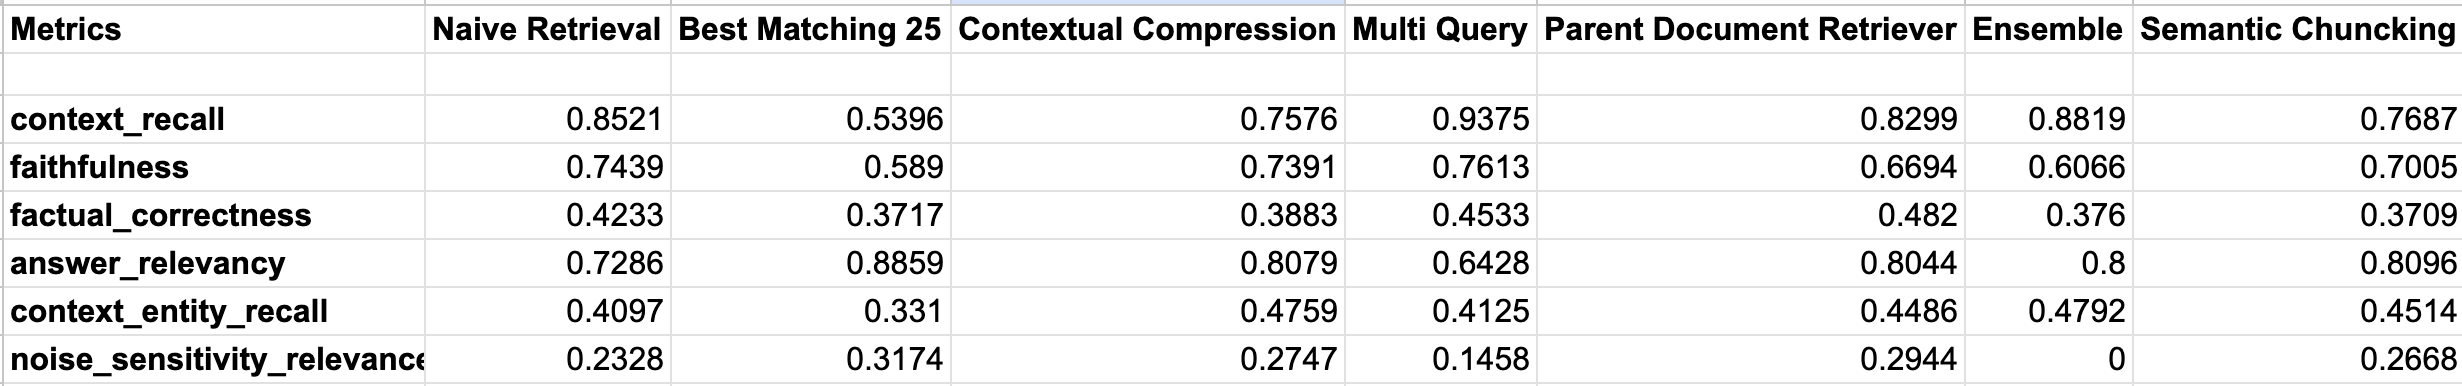
